# Merging radar rain images and wind predictions in a deep learning model applied to rain nowcasting : Training procedure

In [1]:
import os
import sys
import logging
import argparse
from tqdm import tqdm

import torch
import numpy as np
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import samplers
import utilities as utils
from unet_model import UNet
from dataset import MeteoNetDataset
from eval import eval_net_and_persistance

/local/bereziat/conda/env/torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Path to data

In [2]:
# Directory where rain data is stored
rain_dir = r'data/Rain'                      # <- TO COMPLETE
# Directory where wind data are stored
U_dir = r'data/U'                            # <- TO COMPLETE
V_dir = r'data/V'                            # <- TO COMPLETE
# Path to rain radar coordonates file
coord_file = r'data/radar_coords_NW.npz'          # <- TO COMPLETE
# Boolean to save or not the model at the end of each epoch
save_cp = True
# Directory to save checkpoints if save_cp==True
ckp_dir = r'runs'
#Architecture constants
Matrix_path = os.path.join("Matrix", "Matrix")  # Relative path to matrices.

### Model constants

In [3]:
# Number of time steps to use for inputs 
temporal_length_inputs = 12 #1h input
# Number of time steps from the first input to the target
temporal_length = temporal_length_inputs+6 # Prediction at 30m. Set 24 for 1h.
# Thresholds in mm/h and mm
thresholds_in_mmh = [0, 0.1, 1, 2.5]  # CRF over 1h
thresholds_in_cent_mm = [100*k/12 for k in thresholds_in_mmh] # CRF over 5 minutes in 1/100 of millimeters like MN data
# Input and output channels
n_channels = 3*temporal_length_inputs # Factor 3 for rain + U + V
n_classes = len(thresholds_in_cent_mm)-1
# Proportionnal to the number of weights in the model
model_size = 8

### Parameters of the training procedure

In [4]:
batch_size = 32
epochs = 20
percentage_sampling = 0.9 # see paper section oversampling
# Learning rate
lr = {0:0.0008,4:0.0001}
# Cuda, number of loader worker processes.
num_workers = 0
# Weight decay for L2 regularization
wd = {0:1e-5 ,4:5e-5}

In [ ]:
def train(net,
          rain_dir,
          U_dir,
          V_dir,
          ckp_dir,
          device,
          epochs=20,
          batch_size=256,
          lr={0:1e-4},
          save_cp=True,
          num_workers=0,
          n_val_round_by_epoch=3,
          wd={0:1e-5},
          percentage_sampling=0.8):
    
    train = MeteoNetDataset(rain_dir=os.path.join(rain_dir,'train'), 
                            U_dir=os.path.join(U_dir,'train'), 
                            V_dir=os.path.join(V_dir,'train'),
                            temporal_length_inputs=temporal_length_inputs, 
                            temporal_length=temporal_length, 
                            temporal_stride=temporal_length_inputs, 
                            thresholds=thresholds_in_cent_mm, 
                            Matrix_path=Matrix_path)
    val = MeteoNetDataset(rain_dir=os.path.join(rain_dir,'val'), 
                          U_dir=os.path.join(U_dir,'val'), 
                          V_dir=os.path.join(V_dir,'val'),
                          temporal_length_inputs=temporal_length_inputs, 
                          temporal_length=temporal_length, 
                          temporal_stride=temporal_length_inputs, 
                          thresholds=thresholds_in_cent_mm, 
                          Matrix_path=Matrix_path)
    thresholds_normalized = np.log(np.array(thresholds_in_cent_mm)+1)/train.norm_factor
    
    train_sampler, real_percentage = samplers.oversample_xpercent_rainy_tiles(train, p=percentage_sampling, 
                                                                              above_class=len(thresholds_in_cent_mm)-1)
    train_loader = DataLoader(train, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers, pin_memory=True)
    # Custom sampler to consider only defined data
    val_sampler = samplers.CustomSampler(samplers.indices_except_undefined_sampler(val))
    val_loader = DataLoader(val, batch_size=batch_size, sampler=val_sampler, num_workers=num_workers, pin_memory=True, drop_last=True)
    
    writer = SummaryWriter(comment=f'-LR_{lr}_BS_{batch_size}_E_{epochs}_T{temporal_length}_WD_{wd}_p{percentage_sampling}')
    writer.add_scalar('Number_of_parameters', net.get_nb_params())
    info = f'''Starting training:
        Epochs:                {epochs}
        Learning rate:         {lr}
        Batch size:            {batch_size}
        Weight decay:          {wd}
        Number batch train :   {len(train_loader)}
        Number batch val :     {len(val_loader)}
        Training size:         {len(train)}
        Validation size:       {len(val)}
        Checkpoints:           {save_cp}
        Device:                {device.type}
        Number of parameters:  {net.get_nb_params()}
        Thresholds(mm/h):      {thresholds_in_mmh}
        Temporal length:       {temporal_length}
        Normalization factor:  {train.norm_factor}
        Percentage sampling:   {percentage_sampling}
        Real percantage :      {real_percentage}
    '''
    logging.info(info)
    writer.add_text('Description', info)

    global_step = 0
    
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        
        if epoch in lr.keys():
            print('***:',lr[epoch], wd[epoch])
            optimizer = optim.Adam(net.parameters(), lr=lr[epoch], weight_decay=wd[epoch])
            
        net.train()
        epoch_loss = 0
        n_batch = len(train_loader)
        
        with tqdm(total=n_batch, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch') as pbar:
            for batch in train_loader:
                imgs = batch['inputs']  #BC(temp)HW
                true_imgs = batch['target']   #BClsHW
                assert imgs.shape[1] == net.n_channels, \
                    f'Network has been defined with {net.n_channels} input channels, ' \
                    f'but loaded images have {imgs.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'
                   
                imgs = imgs.to(device=device, dtype=torch.float32)
                true_imgs = true_imgs.to(device=device, dtype=torch.float32)
                
                imgs_pred = net(imgs)   #BClsHW
                loss = criterion(imgs_pred, true_imgs)
                epoch_loss += loss.item()
                pbar.set_postfix(**{'loss (epoch)': epoch_loss})
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_value_(net.parameters(), 0.1)
                optimizer.step()
                pbar.update()
                
                if ((global_step % (n_batch//n_val_round_by_epoch))==0):
                    Scores = eval_net_and_persistance(net=net, thresholds=thresholds_normalized, loader=val_loader, device=device)
                    # Log scores
                    for key in Scores.keys():
                        score = Scores[key]
                        if type(score)==type(dict()):
                            writer.add_scalars(f'{key}_val', score, global_step)
                        else :
                            writer.add_scalar(f'{key}_val', score, global_step)
                            
                    # Save images of batch inputs//target, prediction, persistance, (pred-target) and (pers-target) on the last epoch
                    if (epoch==epochs-1):    
                        # we select rain, U and V channels (BCHW)
                        utils.writer_add_batch_rain(rain_channels=imgs[:,:12,:,:],text="Rain_inputs",writer=writer)
                        utils.writer_add_batch_wind(wind_channels=imgs[:,12:24,:,:],text="U_inputs",writer=writer,isU=True)
                        utils.writer_add_batch_wind(wind_channels=imgs[:,24:,:,:],text="V_inputs",writer=writer,isU=False)
                        utils.writer_add_comparison(imgs,true_imgs,imgs_pred,
                                                    text="Target_Prediction_Persistance_Prediction-Target_Persistance-Target",
                                                    writer=writer,thresholds=thresholds_normalized, temporal_length_inputs=temporal_length_inputs)
        
                global_step += 1
        losses = {"lossTot" : epoch_loss}
        writer.add_scalars('Loss_train', losses, epoch)
        
        if save_cp:
            try:
                os.mkdir(ckp_dir)
                logging.info('Created checkpoint directory')
            except OSError:
                pass
            torch.save(net.state_dict(),
                       os.path.join(ckp_dir, f'CP_epoch{epoch + 1}.pth'))
            logging.info(f'Checkpoint {epoch + 1} saved !')
    writer.close()

In [ ]:
if __name__ == '__main__':
    logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logging.info(f'Using device {device}')
    
    net = UNet(n_channels, n_classes, bilinear=True, n=model_size)
    net.to(device=device)
    
    try:
        train(net=net,
              rain_dir=rain_dir,
              U_dir=U_dir,
              V_dir=V_dir,
              ckp_dir=ckp_dir,
              epochs=epochs,
              batch_size=batch_size,
              lr=lr,
              device=device,
              num_workers=num_workers,
              wd = wd,
              percentage_sampling=percentage_sampling,
              save_cp=save_cp)
        
    except KeyboardInterrupt:
        try:
            sys.exit(0)
        except SystemExit:
            os._exit(0)

## Visualizing results

In [ ]:
%load_ext tensorboard
logs_dir = './runs'
%tensorboard --logdir {logs_dir}

### An example of prediction

INFO: Using device cuda
INFO: Model loaded from /local/bereziat/rain-nowcasting-with-fusion-of-rainfall-and-wind-data-article/weigths/model30m.pth
INFO: Creating dataset
/local/bereziat/rain-nowcasting-with-fusion-of-rainfall-and-wind-data-article/unet_parts.py:65: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
/local/bereziat/rain-nowcasting-with-fusion-of-rainfall-and-wind-data-article/unet_parts.py:66: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for n

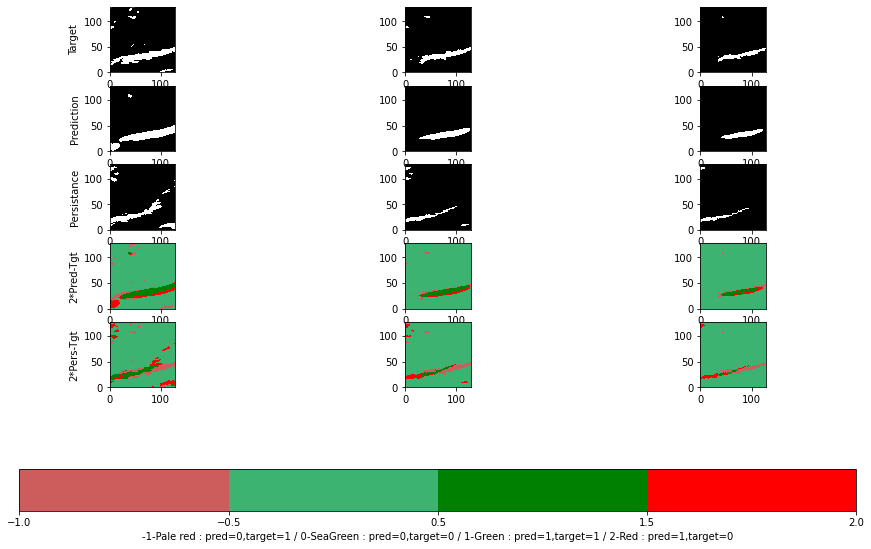

In [5]:
from dataset import DatasetPrediction
directory = os.getcwd()

# Path to model, specify to load a model, otherwise let empty string
model = r'weigths/model30m.pth'
#model = 'runs/CP_epoch20.pth'
model = os.path.join(directory,model)
assert os.path.isfile(model), 'weight file not found'
rain_dir = r'data/pred_example/rain'
rain_dir = os.path.join(directory,rain_dir)
assert os.path.isdir(rain_dir), 'rain file not found'
wind_dir = r'data/pred_example'
wind_dir = os.path.join(directory,wind_dir)
assert os.path.isdir(wind_dir), 'wind file not found'
if __name__ == '__main__':
    logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logging.info(f'Using device {device}')
    
    net = UNet(n_channels, n_classes, bilinear=True, n=model_size)
    net.load_state_dict(
        torch.load(model, map_location=device)
    )
    logging.info(f'Model loaded from {model}')
    net.to(device=device)
    net.eval()
    
    dataset = DatasetPrediction(rain_dir=rain_dir, 
                            U_dir=os.path.join(wind_dir,'U'), 
                            V_dir=os.path.join(wind_dir,'V'),
                            thresholds=thresholds_in_cent_mm)
    thresholds_normalized = np.log(np.array(thresholds_in_cent_mm)+1)/dataset.norm_factor
    dataset_loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)
    batch = next(iter(dataset_loader))
    imgs, true_imgs = batch['inputs'], batch['target']
    imgs = imgs.to(device=device, dtype=torch.float32)
    true_imgs = true_imgs.to(device=device, dtype=torch.float32)
    persistance = utils.batch_to_mapped_persistance(imgs,thresholds_normalized)
    # Network output
    with torch.no_grad():
        imgs_pred = net(imgs)
        
    utils.plot_comparison(imgs,true_imgs,imgs_pred,thresholds_normalized,temporal_length_inputs)
    
    